In [4]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [5]:
%cd "/content/drive/My Drive/Covid19AI"

/content/drive/My Drive/Covid19AI


In [6]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/BEASF.py" .

In [7]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/visualization_tools.py" .

In [8]:
!pip3 install lime

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=deec0ddec5e16d1d2595b7ab71e7aae7ffee5948aa3fb379135ffb6d7c35642f
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [9]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, copy, tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skimage.filters import rank
from skimage.morphology import disk

from BEASF import BEASF
from visualization_tools import GradCAM

# read Data and convert to npy

In [10]:
def get_images(img_path):
  normal_images = list()
  cap_images = list()
  covid_images = list()
  for img_name in glob.glob(pathname=img_path + '/*'):
    img = load_img(path=img_name, color_mode='grayscale')
    img = img_to_array(img=img, data_format='channels_last')
    if 'COVID' in img_name:
      covid_images.append(img)
    elif 'pneumonia' in img_name:
      cap_images.append(img)
    elif 'normal' in img_name:
      normal_images.append(img)
  normal_images = np.array(normal_images)
  cap_images = np.array(normal_images)
  covid_images = np.array(normal_images)

  normal_labels = [0 for _ in range(len(normal_images))]
  cap_labels = [1 for _ in range(len(cap_images))]
  covid_labels = [2 for _ in range(len(covid_images))]

  X = np.concatenate((covid_images, cap_images, normal_images))
  y = np.array(covid_labels + cap_labels + normal_labels)
  return X,y

In [15]:
def resize_images_of(X):
    X = np.array([cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in X])
    X = np.array([np.expand_dims(a=image, axis=-1) for image in X])
    X = X.astype(dtype=np.uint8)
    return X


def show_random_image_from(X):
    rnd_idx = np.random.choice(a=len(X), size=None)
    plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(label='a random image from the dataset')
    plt.show()


def save_dataset(data, labels):
    print('number of total dataset images:', len(data))
    print('number of total dataset labels:', len(labels))
    print('dataset shape:', data.shape)
    print("export images as npy file? (y/n) : default = n need to remove commented code if needed to export")
    """if input() == 'y':
        np.save('./covid_cxr_dataset/cxr_samples.npy', arr=data)
        np.save('./covid_cxr_dataset/cxr_labels.npy', arr=labels)
    else:
        print('dataset exportation aborted.')"""
    print('saved as ./covid_cxr_dataset/cxr_samples.npy')
    print('saved as ./covid_cxr_dataset/cxr_labels.npy')

In [16]:
!ls

 0.Dataset_prep.ipynb	      Jupyter_notebooks
 1.Image_segmentation.ipynb   Pretrained_Model
 2.Training_model.ipynb      'Projects progress.gdoc'
 Additional		      __pycache__
 BEASF.py		      tmp.h5
 covid_cxr_dataset	     'v1.0_eps=099_valAcc=0.9672.hdf5'
 Documents		      visualization_tools.py


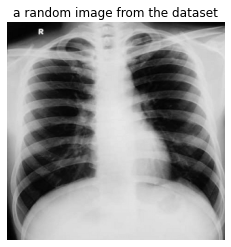

number of total dataset images: 30
number of total dataset labels: 30
dataset shape: (30, 320, 320, 1)
export images as npy file? (y/n) : default = n need to remove commented code if needed to export
saved as ./covid_cxr_dataset/cxr_samples.npy
saved as ./covid_cxr_dataset/cxr_labels.npy


In [17]:
data_path = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/test'

X,y = get_images(img_path=data_path)
X = resize_images_of(X=X)
show_random_image_from(X=X)
save_dataset(data=X, labels=y)

# Verifying the dataset preperation

number of total dataset images: 748
number of total dataset labels: 748
dataset shape: (748, 320, 320, 1)


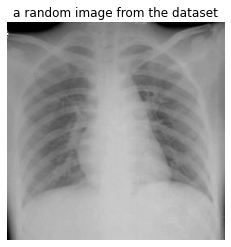

In [18]:
X = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_samples.npy')
y = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_labels.npy')

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

In [19]:
print(y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 